In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
import torchvision
import torchvision.transforms.v2 as T
import torchvision.transforms.v2.functional as F

import datasets
import transforms
import visualize

/home/akors/.conda/envs/ml/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/akors/.conda/envs/ml/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you

## Dataset loading

In [3]:
dataroot = '../data/'

In [4]:
ds_train = torchvision.datasets.VOCSegmentation(root=dataroot, year="2012", image_set="train", download=False)

In [5]:
ds_train_v2 = torchvision.datasets.wrap_dataset_for_transforms_v2(ds_train)

In [6]:
tr_inv_norm = transforms.inv_normalize(datasets.DATASET_STATS["2012"]["rgb_mean"], datasets.DATASET_STATS["2012"]["rgb_std"])

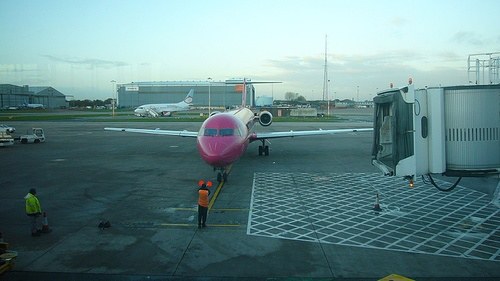

In [7]:
ds_train[0][0]

## Individual Transforms

In [8]:
def tensorinfo(t: torch.Tensor):
    info = "type=" + str(type(t))
    if not isinstance(t, torch.Tensor):
        return info
    
    info += "; dtype=" + str(t.dtype)
    info += "; shape=" + str(t.shape)
    info += "; minmax=" + str([t.min().item(), t.max().item()])
    return info

In [9]:
mean, std = datasets.DATASET_STATS["2012"]["rgb_mean"], datasets.DATASET_STATS["2012"]["rgb_std"]

In [10]:
input_sample = ds_train_v2[0]

In [11]:
img, mask = input_sample

In [12]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'PIL.Image.Image'>
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 281, 500]); minmax=[0, 255]


In [13]:
tr = T.ToImageTensor()

In [14]:
img, mask = tr(input_sample)

In [15]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.uint8; shape=torch.Size([3, 281, 500]); minmax=[0, 255]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 281, 500]); minmax=[0, 255]


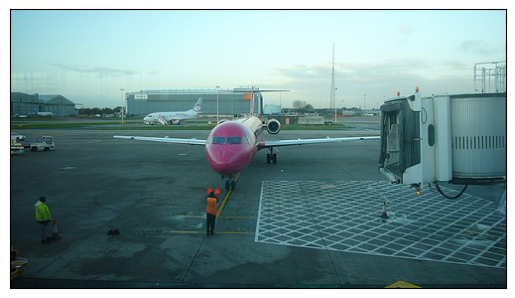

In [16]:
visualize.imshow_tensor(img)

### Clip superfluous mask classes (like boundary region)

Clip all classes higher than a maximum (20 for Pascal VOC) to be background.

In [17]:
tr = transforms.ClipMaskClasses(transforms.PASCAL_VOC_OBJECT_CLASS_MAX)

In [18]:
tr_clipmask = tr

In [19]:
# save current sample state as starting point to show other transforms
input_sample = tr((img, mask))

In [20]:
img, mask = tr(input_sample)

In [21]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.uint8; shape=torch.Size([3, 281, 500]); minmax=[0, 255]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 281, 500]); minmax=[0, 15]


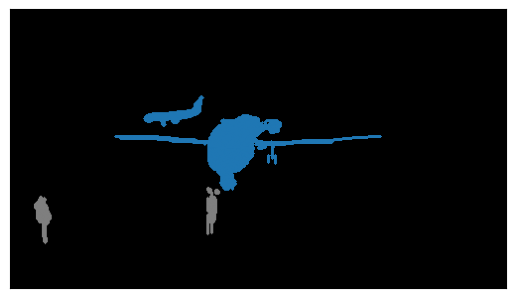

In [22]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask)[0,:])

### Resize + Center crop

Maybe use for inference instead of RWP?

In [23]:
tr = T.Resize(256, antialias=True)

In [24]:
img, mask = tr(input_sample)

In [25]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.uint8; shape=torch.Size([3, 256, 455]); minmax=[0, 255]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 256, 455]); minmax=[0, 15]


In [26]:
input_sample[1].unique()

tensor([ 0,  1, 15], dtype=torch.uint8)

In [27]:
mask.unique()

tensor([ 0,  1, 15], dtype=torch.uint8)

In [28]:
tr = T.CenterCrop(256)

In [29]:
img, mask = tr((img, mask))

In [30]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.uint8; shape=torch.Size([3, 256, 256]); minmax=[3, 255]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 256, 256]); minmax=[0, 15]


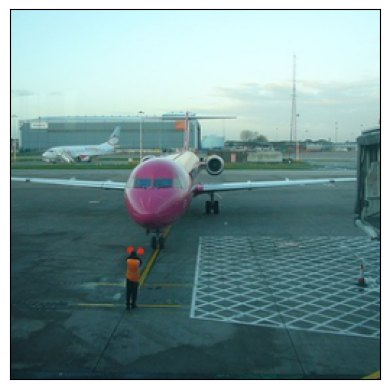

In [31]:
visualize.imshow_tensor(img)

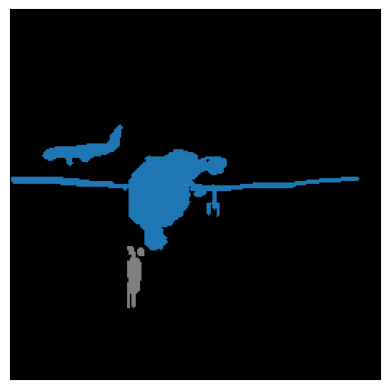

In [32]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask)[0,:])

### Resize with pad

Applies to:
 - PIL
 - Tensor
 - Image
 - Mask

In [33]:
tr = transforms.Resize_with_pad(256,256)

In [34]:
img, mask = tr(input_sample)

In [35]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.uint8; shape=torch.Size([3, 256, 256]); minmax=[0, 255]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 256, 256]); minmax=[0, 15]


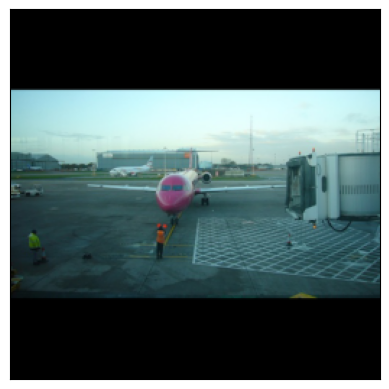

In [36]:
visualize.imshow_tensor(img)

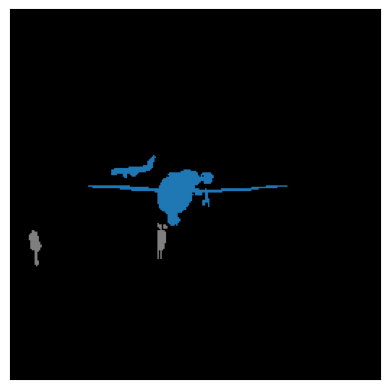

In [37]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask)[0,:])

### Random Gaussian Blur

In [38]:
import torchvision.transforms.v2.functional as F


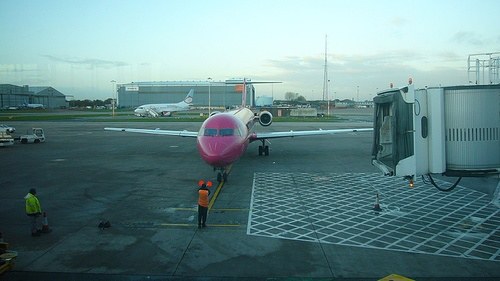

In [39]:
# original
ds_train_v2[0][0]

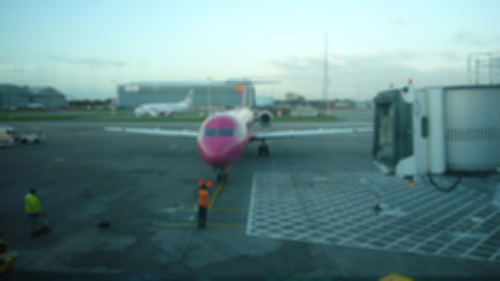

In [40]:
# size 5, sigma 2: too much!
F.gaussian_blur(ds_train_v2[0][0], kernel_size=5, sigma=2)

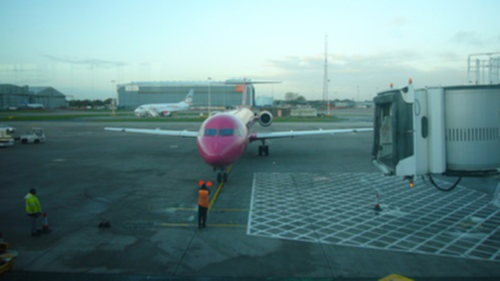

In [41]:
# smaller kernel size, looks about the same from afar, but more detail preserved
F.gaussian_blur(ds_train_v2[0][0], kernel_size=3, sigma=1)

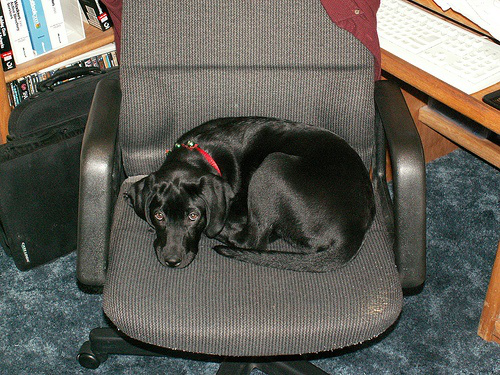

In [42]:
# original
ds_train_v2[2][0]

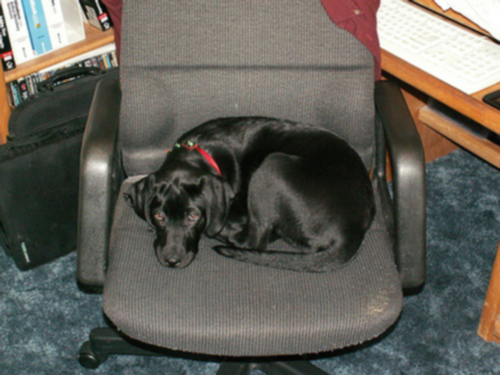

In [43]:
# size 3, sigma 1: about right
F.gaussian_blur(ds_train_v2[2][0], kernel_size=3, sigma=1)

In [44]:
kernel_size = 5
sigma = (0.1, 2.0) # torch default is (0.1, 2.0)

In [45]:
tr = T.GaussianBlur(kernel_size=kernel_size, sigma=sigma)

In [46]:
img, mask = tr(input_sample)

In [47]:
img = F.gaussian_blur(ds_train_v2[0][0], kernel_size=kernel_size, sigma=.7)
mask = F.gaussian_blur(ds_train_v2[0][1], kernel_size=kernel_size, sigma=.2)

In [48]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'PIL.Image.Image'>
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 281, 500]); minmax=[0, 255]


In [49]:
input_sample[1].unique()

tensor([ 0,  1, 15], dtype=torch.uint8)

In [50]:
mask.unique()

tensor([  0,   1,  15, 255], dtype=torch.uint8)

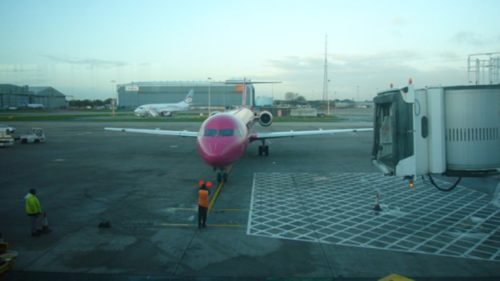

In [51]:
img

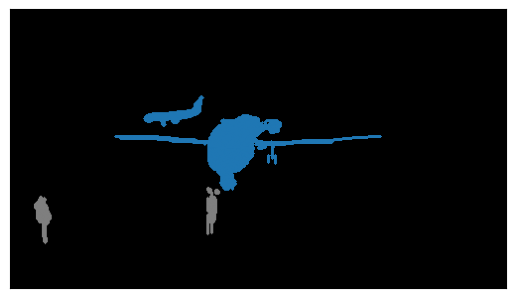

In [52]:
visualize.imshow_tensor(visualize.classmask_to_colormask(tr_clipmask(mask))[0,:])

### Random Resized Crop

In [53]:
tr = T.RandomResizedCrop(size=256, scale=(0.3, 1.0), ratio=(1,1), antialias=True)

In [54]:
img, mask = tr(input_sample)

In [55]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.uint8; shape=torch.Size([3, 256, 256]); minmax=[0, 255]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 256, 256]); minmax=[0, 1]


In [56]:
input_sample[1].unique()

tensor([ 0,  1, 15], dtype=torch.uint8)

In [57]:
mask.unique()

tensor([0, 1], dtype=torch.uint8)

In [58]:
img

Image([[[223, 223, 223,  ..., 201, 201, 201],
        [223, 223, 223,  ..., 202, 202, 202],
        [223, 223, 223,  ..., 200, 200, 200],
        ...,
        [ 28,  27,  27,  ...,  67,  65,  58],
        [ 28,  28,  27,  ...,  67,  72,  80],
        [ 30,  30,  28,  ...,  59,  64,  66]],

       [[254, 254, 254,  ..., 243, 243, 243],
        [254, 254, 254,  ..., 244, 244, 244],
        [254, 254, 254,  ..., 242, 242, 242],
        ...,
        [ 53,  52,  52,  ..., 112, 112, 106],
        [ 53,  53,  53,  ..., 107, 114, 123],
        [ 55,  55,  56,  ...,  94, 101, 103]],

       [[255, 255, 255,  ..., 242, 242, 242],
        [255, 255, 255,  ..., 243, 243, 243],
        [255, 255, 255,  ..., 241, 241, 241],
        ...,
        [ 57,  56,  56,  ..., 117, 116, 111],
        [ 57,  57,  56,  ..., 113, 120, 129],
        [ 59,  59,  59,  ..., 100, 107, 109]]], dtype=torch.uint8, )

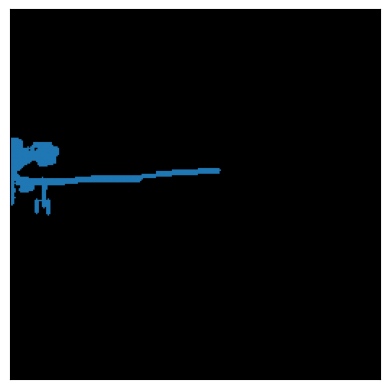

In [59]:
visualize.imshow_tensor(visualize.classmask_to_colormask(tr_clipmask(mask))[0,:])

### ColorJitter

In [60]:
# float dtype required for normalization
tr = T.ColorJitter(brightness=.3, hue=.2, contrast=.4, saturation=.3)

In [61]:
input_sample = ds_train_v2[0]

In [62]:
img, mask = tr(input_sample)

In [63]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'PIL.Image.Image'>
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 281, 500]); minmax=[0, 255]


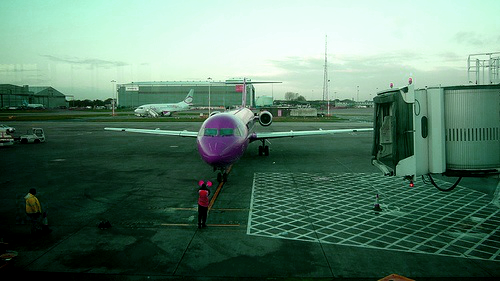

In [64]:
img

In [65]:
torch.std_mean(F.to_tensor(img), dim=(1,2))

/home/akors/.conda/envs/ml/lib/python3.10/site-packages/torchvision/transforms/v2/functional/_deprecated.py:27: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image_tensor(...)` followed by `convert_image_dtype(...)`.
  warnings.warn(


(tensor([0.3431, 0.3494, 0.3447]), tensor([0.3515, 0.4829, 0.4102]))

### Normalize

In [66]:
# tensor of float dtype required for normalization
tr = T.Compose([
    T.ToImageTensor(),
    T.ConvertImageDtype(torch.float32),
    T.Normalize(mean=mean, std=std)
])

In [67]:
img, mask = tr(input_sample)

In [68]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.float32; shape=torch.Size([3, 281, 500]); minmax=[-1.6842312812805176, 2.0932445526123047]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 281, 500]); minmax=[0, 255]


In [69]:
torch.std_mean(img)

(tensor(1.0997), tensor(0.1973))

2023-05-17 16:14:33,649 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


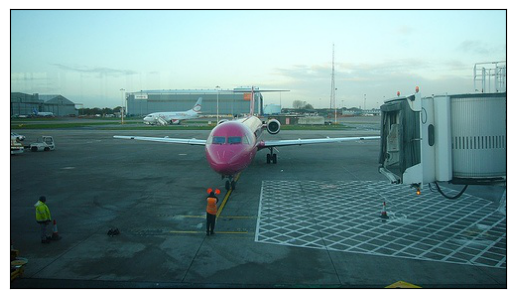

In [70]:
# apply reverse normalization transform to properly display image
visualize.imshow_tensor(tr_inv_norm(img))

## Composed Transforms

### Inference Transforms

In [71]:
tr = transforms.make_transforms(datasets.DATASET_STATS["2012"]["rgb_mean"], datasets.DATASET_STATS["2012"]["rgb_std"])

In [72]:
input_sample = ds_train_v2[0]

In [73]:
img, mask = tr(input_sample)

In [74]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.float32; shape=torch.Size([3, 256, 256]); minmax=[-1.6408590078353882, 2.0932445526123047]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 256, 256]); minmax=[0, 15]


2023-05-17 16:14:34,056 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


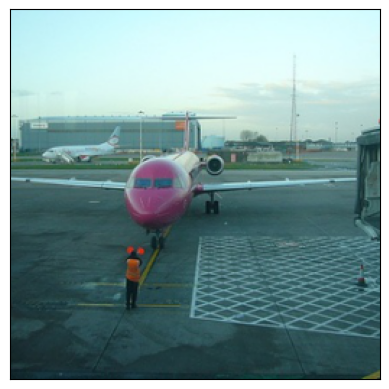

In [75]:
visualize.imshow_tensor(tr_inv_norm(img))

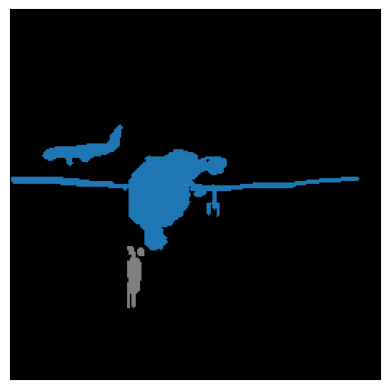

In [76]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask)[0,:])

### Training Transforms with augmentation

In [77]:
tr = transforms.make_transforms(datasets.DATASET_STATS["2012"]["rgb_mean"], datasets.DATASET_STATS["2012"]["rgb_std"], augment_level=2)

In [78]:
input_sample = ds_train_v2[0]

In [79]:
img, mask = tr(input_sample)

In [80]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torchvision.datapoints._image.Image'>; dtype=torch.float32; shape=torch.Size([3, 256, 256]); minmax=[-1.525593638420105, 2.0794551372528076]
mask:  type=<class 'torchvision.datapoints._mask.Mask'>; dtype=torch.uint8; shape=torch.Size([1, 256, 256]); minmax=[0, 15]


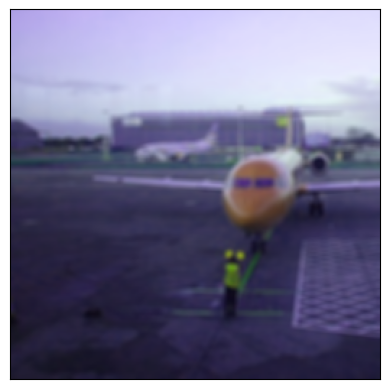

In [81]:
visualize.imshow_tensor(tr_inv_norm(img))

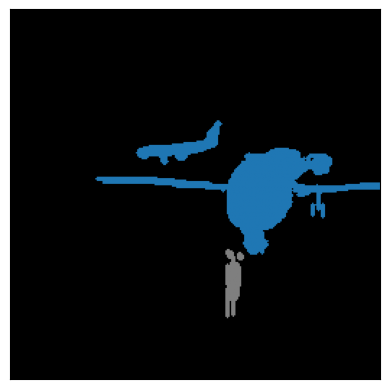

In [82]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask)[0,:])

## Complete Dataset transforms

In [83]:
import datasets

In [84]:
ds_train, ds_val = datasets.make_datasets(datadir='../data/')

In [85]:
val_dataloader = torch.utils.data.DataLoader(ds_val, batch_size=8, shuffle=False)

In [86]:
train_dataloader = torch.utils.data.DataLoader(ds_train, batch_size=8, shuffle=False)

In [87]:
img, mask = next(iter(train_dataloader))

In [88]:
print("img: ", tensorinfo(img))
print("mask: ", tensorinfo(mask))

img:  type=<class 'torch.Tensor'>; dtype=torch.float32; shape=torch.Size([8, 3, 256, 256]); minmax=[-1.6697739362716675, 2.0932445526123047]
mask:  type=<class 'torch.Tensor'>; dtype=torch.uint8; shape=torch.Size([8, 1, 256, 256]); minmax=[0, 20]


2023-05-17 16:14:35,352 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


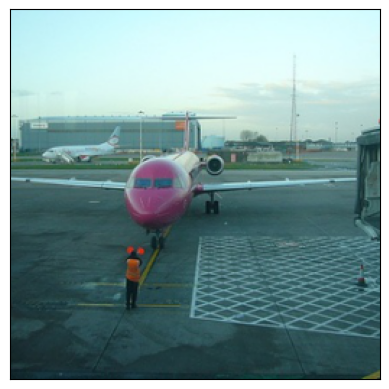

In [89]:
visualize.imshow_tensor(tr_inv_norm(img[0,:]))

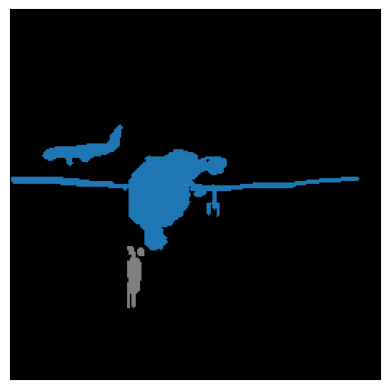

In [90]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask[:,0,:,:])[0])

In [91]:
img, mask = next(iter(val_dataloader))

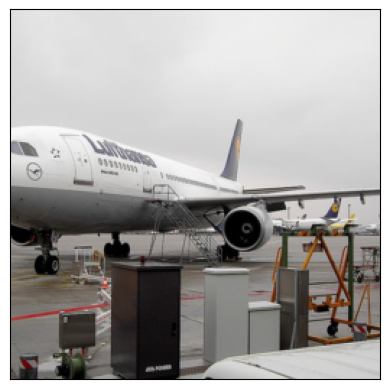

In [92]:
visualize.imshow_tensor(tr_inv_norm(img[0,:]))

In [93]:
mask.shape

torch.Size([8, 1, 256, 256])

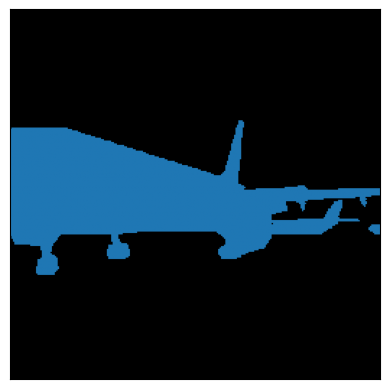

In [94]:
visualize.imshow_tensor(visualize.classmask_to_colormask(mask[:,0,:,:])[0])